In [1]:
import pyart
import glob
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import sys
import fiona
import geopandas as gpd
fiona.drvsupport.supported_drivers['lib?kml'] = 'rw' # enable KML support which is disabled by default
fiona.drvsupport.supported_drivers['LIBKML'] = 'rw' # enable KML support which is disabled by default



## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



<frozen importlib._bootstrap>:283: DeprecationWarning: the load_module() method is deprecated and slated for removal in Python 3.12; use exec_module() instead
ERROR 1: PROJ: proj_create_from_database: Open of /ccsopen/home/braut/analysis-env/share/proj failed


In [2]:
hour = '19'
day = '25'
month = '08'
year = '2022'

files = sorted(glob.glob(f'/gpfs/wolf/atm124/proj-shared/gucxprecipradarS2.00/glue_files/{year}{month}_glued/xprecipradar_guc_volume_{year}{month}{day}-{hour}*'))

In [3]:
radar = pyart.io.read(files[-3])

(-20.0, 20.0)

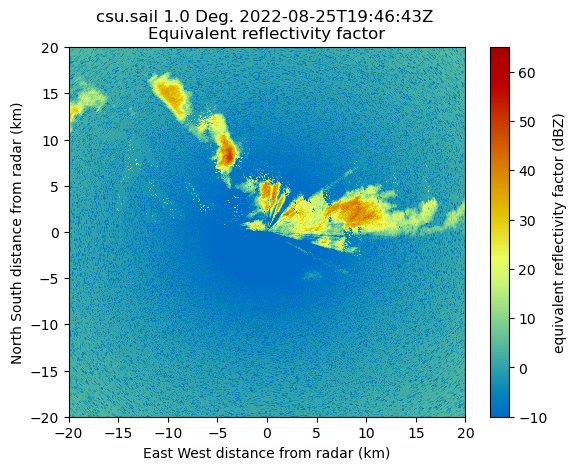

In [4]:
display = pyart.graph.RadarDisplay(radar)
display.plot('DBZ')
plt.xlim(-20, 20)
plt.ylim(-20, 20)

In [5]:
nyquist_value = radar.fields['VEL']['data'].max()
vel_texture = pyart.retrieve.calculate_velocity_texture(radar,
                                                        vel_field='VEL',
                                                        nyq=nyquist_value)

radar.add_field('velocity_texture', vel_texture, replace_existing=True)

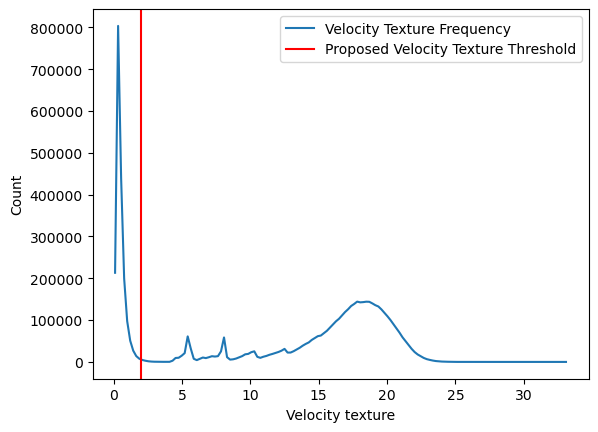

In [6]:
hist, bins = np.histogram(radar.fields['velocity_texture']['data'],
                          bins=150)
bins = (bins[1:]+bins[:-1])/2.0

plt.plot(bins,
         hist,
         label='Velocity Texture Frequency')
plt.axvline(2,
            color='r',
            label='Proposed Velocity Texture Threshold')

plt.xlabel('Velocity texture')
plt.ylabel('Count')
plt.legend()

In [7]:
gatefilter = pyart.filters.GateFilter(radar)
gatefilter.exclude_above('velocity_texture', 3)

(-20.0, 20.0)

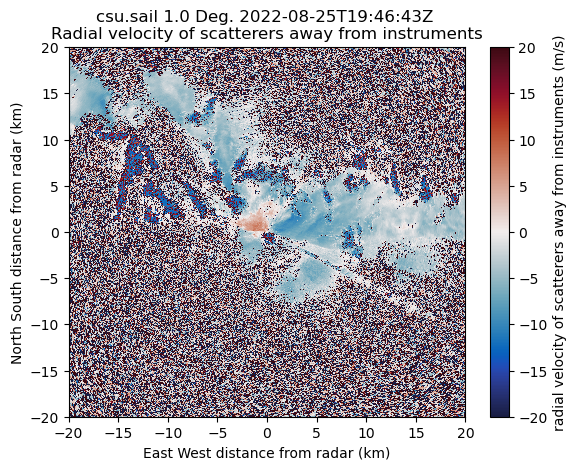

In [8]:
display = pyart.graph.RadarDisplay(radar)
display.plot('VEL', vmin=-20, vmax=20, cmap='pyart_balance')
plt.xlim(-20, 20)
plt.ylim(-20, 20)

(-20.0, 20.0)

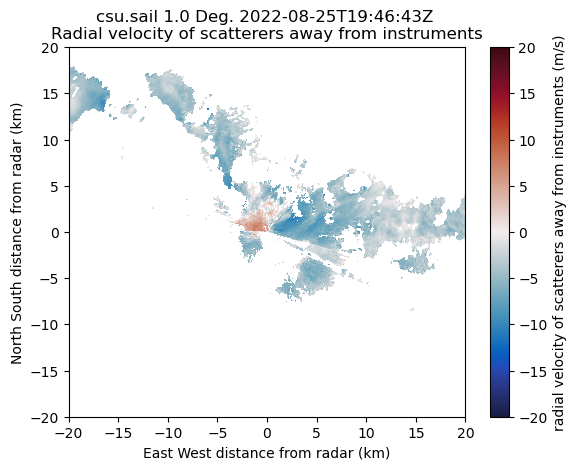

In [9]:
display = pyart.graph.RadarDisplay(radar)
display.plot('VEL', gatefilter=gatefilter, vmin=-20, vmax=20, cmap='pyart_balance')
plt.xlim(-20, 20)
plt.ylim(-20, 20)

In [10]:
phidp_texture = pyart.retrieve.texture_of_complex_phase(radar, phidp_field='PHIDP', phidp_texture_field='phidp_texture')

phidp_texture
radar.add_field('phidp_texture', phidp_texture, replace_existing=True)

(-30.0, 30.0)

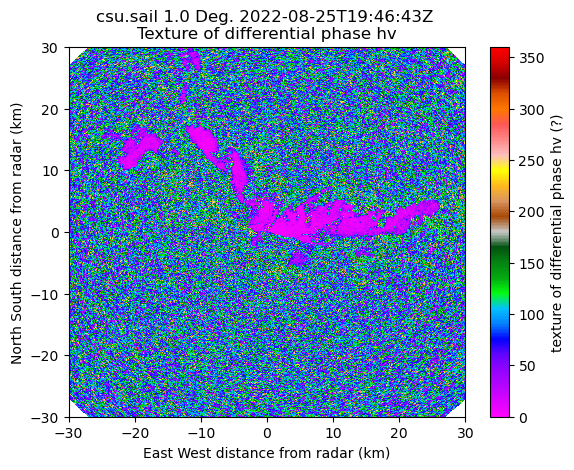

In [11]:
display = pyart.graph.RadarDisplay(radar)
display.plot('phidp_texture', cmap='pyart_Wild25', vmin=0, vmax=360)
plt.xlim(-30, 30)
plt.ylim(-30, 30)

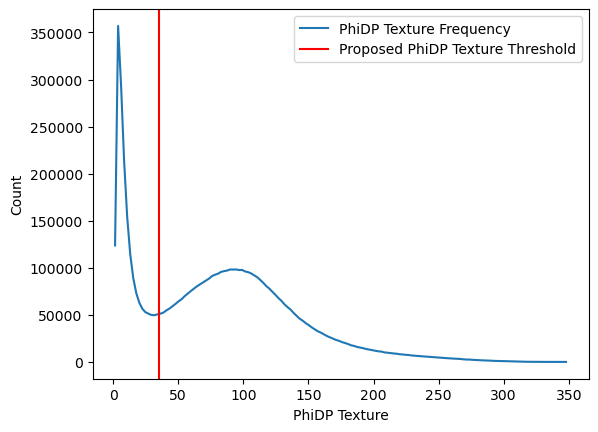

In [12]:
hist, bins = np.histogram(radar.fields['phidp_texture']['data'],
                          bins=150)
bins = (bins[1:]+bins[:-1])/2.0

plt.plot(bins,
         hist,
         label='PhiDP Texture Frequency')
plt.axvline(35,
            color='r',
            label='Proposed PhiDP Texture Threshold')

plt.xlabel('PhiDP Texture')
plt.ylabel('Count')
plt.legend()

(-30.0, 30.0)

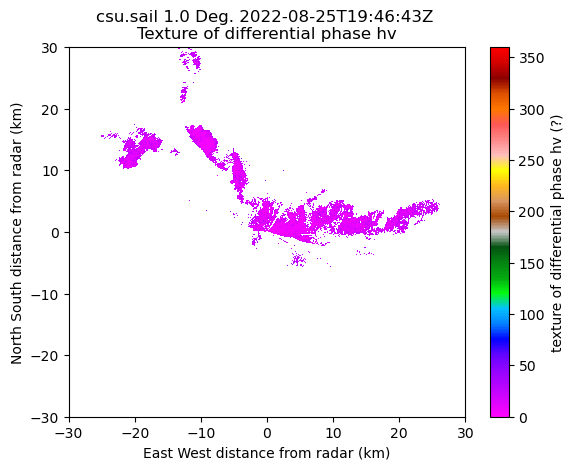

In [13]:
gatefilter = pyart.filters.GateFilter(radar)
gatefilter.exclude_above('phidp_texture', 30)
gatefilter.exclude_above('velocity_texture', 10)

display = pyart.graph.RadarDisplay(radar)
display.plot('phidp_texture', gatefilter=gatefilter, cmap='pyart_Wild25', vmin=0, vmax=360)
plt.xlim(-30, 30)
plt.ylim(-30, 30)

In [14]:
list(radar.fields)

['DBZ',
 'VEL',
 'WIDTH',
 'ZDR',
 'PHIDP',
 'RHOHV',
 'NCP',
 'SNR',
 'DBZhv',
 'velocity_texture',
 'phidp_texture']

# KDP Computation

In [15]:
# Maesaka Method
kdp, _for_kdp, r_kdp = pyart.retrieve.kdp_maesaka(radar, gatefilter=gatefilter, refl_field='DBZhv',
                                                  psidp_field='PHIDP')
radar.fields['KDP_maesaka']=kdp

/ccsopen/home/braut/analysis-env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [16]:
def kdp(radar, refl_field='DBZ', psidp_field='PHIDP', gatefilter=None, method=None):
    """
    Computes KDP using given method and attach it to a pyart.Radar object.

    """
    if method is None:
        sys.exit(" Choose method: 'maesaka', 'schneebeli', 'vulpiani' ")
    elif method == 'maesaka':
        kdp, _for_kdp, r_kdp = pyart.retrieve.kdp_maesaka(radar, gatefilter=gatefilter, refl_field=refl_field, psidp_field=psidp_field)
    elif method == 'schneebeli':
        kdp, _for_kdp, r_kdp = pyart.retrieve.kdp_schneebeli(radar, gatefilter=gatefilter, psidp_field=psidp_field)
    elif method == 'vulpiani':
        kdp, _for_kdp, r_kdp = pyart.retrieve.kdp_vulpiani(radar, gatefilter=gatefilter, psidp_field=psidp_field, band='X')
    else:
        sys.exit(" Wrong method name. Choose method: 'maesaka', 'schneebeli', 'vulpiani' ")
    kdp_field_name = 'kdp_' + method
    
    radar.fields[kdp_field_name]=kdp
    return radar

In [ ]:
radar = kdp(radar, gatefilter=gatefilter, method='maesaka')

In [ ]:
display = pyart.graph.RadarDisplay(radar)
display.plot('kdp_maesaka', vmin=0, vmax=4, cmap='pyart_Carbone42',)
plt.xlim(-20, 20)
plt.ylim(-20, 20)

In [ ]:
PHIDP_UNFOLD = pyart.correct.dealias_unwrap_phase(radar,
                                                   gatefilter=gatefilter,
                                                   skip_checks=True,
                                                   vel_field='PHIDP',
                                                   nyquist_vel=90)
radar.add_field_like('PHIDP', 'PHIDP_UNFOLD', PHIDP_UNFOLD['data'])

In [ ]:

PHIDP_UF_LP, KDP_UF_LP = pyart.correct.phase_proc_lp(radar, 0.0,
                                                   ncp_field='NCP',
                                                   refl_field='DBZ',
                                                   rhv_field='RHOHV',
                                                   phidp_field='PHIDP_UNFOLD')


In [ ]:
radar.fields['PHIDP_UF_LP']=PHIDP_UF_LP
radar.fields['KDP_UF_LP']=KDP_UF_LP

In [ ]:
display = pyart.graph.RadarDisplay(radar)
display.plot('KDP_UF_LP', vmin=0,  vmax=4, cmap='pyart_Carbone42')
plt.xlim(-20, 20)
plt.ylim(-20, 20)
plt.savefig('fig.png')

In [ ]:
radar.fields['KDP_UF_LP']['data'].max()

In [ ]:
display = pyart.graph.RadarDisplay(radar)
display.plot('PHIDP_LP', gatefilter=gatefilter, vmin=0, vmax=50, cmap='pyart_balance')
plt.xlim(-20, 20)
plt.ylim(-20, 20)

In [ ]:
radar.info()

